# RAG Pipeline

This notebook contains the full pipeline structure. Fill in sections as needed.


## 1. Install Dependencies

In [1]:
!pip install langchain langchain-community langchain-groq sentence-transformers faiss-cpu langgraph ragas pypdf spacy rank-bm25 transformers accelerate pinecone-client pinecone-text

In [2]:
!python -m spacy download en_core_web_sm

     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
      --------------------------------------- 0.3/12.8 MB ? eta -:--:--
     --------------------------------------  12.6/12.8 MB 65.9 MB/s eta 0:00:01
     ---------------------------------------- 12.8/12.8 MB 53.6 MB/s  0:00:00
[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


## 2. Load PDF

In [18]:
from langchain_community.document_loaders import PyMuPDFLoader
pdf_path = "Deepseek-r1.pdf"
loader = PyMuPDFLoader(pdf_path)
docs = loader.load()
len(docs)

22

## 3. Cleaning Functions

In [19]:
import re

def clean_text(text):
    text = re.sub(r"-\n", "", text)  # fix hyphen-newlines
    text = re.sub(r"\n", " ", text)  # flatten newlines
    text = re.sub(r"\s+", " ", text)
    return text.strip()

cleaned_docs = []
for d in docs:
    cleaned_docs.append(clean_text(d.page_content))

## 4. Chunking

In [20]:
from langchain_text_splitters import RecursiveCharacterTextSplitter
import spacy

# load spacy for semantic chunking
nlp = spacy.load("en_core_web_sm")

# 1. Fixed Chunking
fixed_splitter = RecursiveCharacterTextSplitter(
    chunk_size=500,
    chunk_overlap=50
)

fixed_chunks = fixed_splitter.create_documents(cleaned_docs)

# 2. Semantic Chunking
def semantic_chunk(text, max_tokens=120):
    doc = nlp(text)
    chunks = []
    current = []

    for sent in doc.sents:
        current.append(sent.text)
        if len(" ".join(current).split()) > max_tokens:
            chunks.append(" ".join(current))
            current = []
    if current:
        chunks.append(" ".join(current))
    return chunks

semantic_chunks = []
for d in cleaned_docs:
    semantic_chunks.extend(semantic_chunk(d))

print("Fixed chunks:", len(fixed_chunks))
print("Semantic chunks:", len(semantic_chunks))

Fixed chunks: 136
Semantic chunks: 75


## 5.1. Initialize Embedding Model


In [21]:
from sentence_transformers import SentenceTransformer
import os
from dotenv import load_dotenv

# Load environment variables
load_dotenv()

# Initialize embedding model
embed_model = SentenceTransformer("BAAI/bge-large-en-v1.5")

## 5.2. Pinecone Vector Database

In [22]:
from rank_bm25 import BM25Okapi
import numpy as np
from pinecone import Pinecone, ServerlessSpec
import os

# Get Pinecone API key from environment variables
PINECONE_API_KEY = os.getenv("PINECONE_API_KEY")
if not PINECONE_API_KEY:
    raise ValueError("Please set PINECONE_API_KEY environment variable or configure it in .env file")

pc = Pinecone(api_key=PINECONE_API_KEY)

index_name = "rag-semantic-index"

if index_name not in pc.list_indexes().names():
    pc.create_index(
        name=index_name,
        dimension=embed_model.get_sentence_embedding_dimension(),
        metric="cosine",
        spec=ServerlessSpec(
            cloud="aws",
            region="us-east-1"
        )
    )

index = pc.Index(index_name)

In [23]:
vectors = []
batch_size = 100  # Process in batches to avoid uploading too many at once

for i, text in enumerate(semantic_chunks):
    emb = embed_model.encode(text, show_progress_bar=False).tolist()
    vectors.append({
        "id": str(i),
        "values": emb,
        "metadata": {"text": text[:500]}  # Limit metadata length
    })

# Batch upload
for i in range(0, len(vectors), batch_size):
    batch = vectors[i:i + batch_size]
    index.upsert(vectors=batch)
    print(f"Uploaded {min(i + batch_size, len(vectors))}/{len(vectors)} vectors")

print(f"All vectors uploaded, total: {len(vectors)}")

Uploaded 75/75 vectors
All vectors uploaded, total: 75


## 5.3. Reranker model


In [24]:
# Initialize BM25
tokenized_corpus = [doc.split() for doc in semantic_chunks]
bm25 = BM25Okapi(tokenized_corpus)

def vector_search_pinecone(query, top_k=10):

    q_emb = embed_model.encode(query, show_progress_bar=False).tolist()
    res = index.query(
        vector=q_emb,
        top_k=top_k,
        include_metadata=True
    )
    return res.get("matches", [])

def hybrid_search(query, alpha=0.5, top_k=10):

    # BM25 scores
    query_tokens = query.split()
    if not query_tokens:
        return []
    
    bm25_scores = bm25.get_scores(query_tokens)
    
    # Normalize BM25 scores
    if np.max(bm25_scores) - np.min(bm25_scores) > 1e-9:
        bm25_norm = (bm25_scores - np.min(bm25_scores)) / (np.max(bm25_scores) - np.min(bm25_scores))
    else:
        bm25_norm = np.ones_like(bm25_scores) * 0.5

    # Pinecone vector search
    vector_results = vector_search_pinecone(query, top_k=top_k * 2)  # Get more candidates
    
    vector_scores = np.zeros(len(semantic_chunks))
    for m in vector_results:
        idx = int(m["id"])
        if 0 <= idx < len(semantic_chunks):
            vector_scores[idx] = m.get("score", 0.0)

    # Normalize vector scores
    if np.max(vector_scores) - np.min(vector_scores) > 1e-9:
        vector_norm = (vector_scores - np.min(vector_scores)) / (np.max(vector_scores) - np.min(vector_scores))
    else:
        vector_norm = np.ones_like(vector_scores) * 0.5

    # Hybrid score
    hybrid = alpha * bm25_norm + (1 - alpha) * vector_norm

    # Top K results
    best_idx = np.argsort(hybrid)[::-1][:top_k]

    return [(i, float(hybrid[i]), semantic_chunks[i]) for i in best_idx]

In [25]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch

print("Loading Reranker model...")
reranker_model = AutoModelForSequenceClassification.from_pretrained(
    "BAAI/bge-reranker-base"
)
reranker_tokenizer = AutoTokenizer.from_pretrained("BAAI/bge-reranker-base")
reranker_model.eval()  # Set to evaluation mode
print("Reranker model loaded")

def rerank(query, candidates, top_k=5):

    if not candidates:
        return []
    
    pairs = [[query, c[2]] for c in candidates]
    inputs = reranker_tokenizer(
        pairs,
        padding=True,
        truncation=True,
        max_length=512,  # Limit max length
        return_tensors="pt"
    )
    
    with torch.no_grad():
        scores = reranker_model(**inputs).logits.squeeze()
    
    # Handle single result case
    if scores.dim() == 0:
        scores = scores.unsqueeze(0)
    
    scored = list(zip(scores.tolist(), candidates))
    scored.sort(key=lambda x: x[0], reverse=True)

    return scored[:top_k]

Loading Reranker model...
Reranker model loaded


## 6. Groq LLM (RAG Generation)

In [130]:
from langchain_groq import ChatGroq
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.messages import HumanMessage, AIMessage
import os
from typing import List, Tuple, Optional
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

# Get Groq API key from environment variables
GROQ_API_KEY = os.getenv("GROQ_API_KEY")

os.environ["GROQ_API_KEY"] = GROQ_API_KEY

# Initialize LLM
llm = ChatGroq(
    model="openai/gpt-oss-120b",
    temperature=0.1,
    max_tokens=1000
)
print("Groq LLM initialized")

def retrieve(query, top_k=5, alpha=0.5):

    # Hybrid search
    hybrid_results = hybrid_search(query, alpha=alpha, top_k=20)
    
    if not hybrid_results:
        print("No relevant documents found")
        return []
    
    # Rerank
    reranked_results = rerank(query, hybrid_results, top_k=top_k)
    
    # Extract texts
    retrieved_texts = [r[1][2] for r in reranked_results]
    return retrieved_texts
    
def rag_answer(query, top_k=5):
    
    # Retrieve relevant documents
    ctx = retrieve(query, top_k=top_k)
    
    if not ctx:
        return "Sorry, no relevant information found."
    
    # Build prompt
    context_text = "\n\n".join([f"[Document {i+1}]: {text}" for i, text in enumerate(ctx)])
    
    prompt = f"""Answer the question based on the following context. If the context does not contain relevant information, please state so.

Context:
{context_text}

Question: {query}

Answer:"""
    
    # Call LLM
    response = llm.invoke(prompt)
    
    # Extract text content
    if hasattr(response, 'content'):
        return response.content
    else:
        return str(response)

# Test
test_query = "What is the main contribution of DeepSeek-R1?"
print(f"\nTest query: {test_query}")
answer = rag_answer(test_query)
print(f"\nAnswer:\n{answer}")

Groq LLM initialized

Test query: What is the main contribution of DeepSeek-R1?

Answer:
The principal contribution of **DeepSeek‑R1** is a new training pipeline that combines a small, high‑quality “cold‑start” dataset of long, human‑friendly Chains‑of‑Thought with reinforcement‑learning fine‑tuning. By first fine‑tuning the base model on this readable CoT data and then applying RL, DeepSeek‑R1 produces a model that:

* Generates clear, coherent, and user‑friendly Chains‑of‑Thought, addressing the readability and language‑mixing problems observed in DeepSeek‑R1‑Zero.  
* Retains the strong reasoning and general‑purpose capabilities of the underlying model.  

In short, DeepSeek‑R1’s main contribution is the **integration of a human‑oriented cold‑start fine‑tuning step with RL to create a reasoning model that is both powerful and easy to read**.


In [ ]:
from langchain_groq import ChatGroq
import numpy as np
import re

# LLM Judge wrapper
class GroqJudge:
    def __init__(self, model: str = 'openai/gpt-oss-120b'):
        self.llm = ChatGroq(model=model, temperature=0.0)

    def __call__(self, prompt: str) -> str:
        r = self.llm.invoke(prompt)
        return r.content if hasattr(r, 'content') else str(r)


judge_llm = GroqJudge()


# Faithfulness evaluation
def evaluate_faithfulness(answer: str, contexts: List[str]) -> float:
    contexts_text = '\n\n'.join([f'[Document {i+1}]: {c}' for i, c in enumerate(contexts)])
    prompt = f"""You are an evaluator. Evaluate how faithful the answer is to the context.

Context:
{contexts_text}

Answer:
{answer}

Output only a number 0-1."""
    text = judge_llm(prompt)
    m = re.search(r'0?\.\d+|1\.0|0', text)
    return float(m.group()) if m else 0.0


# Relevance evaluation
def evaluate_relevance(question: str, answer: str) -> float:
    prompt = f"""Evaluate how well the answer responds to the question.

Question:
{question}

Answer:
{answer}

Output only a number 0-1."""
    text = judge_llm(prompt)
    m = re.search(r'0?\.\d+|1\.0|0', text)
    return float(m.group()) if m else 0.0


def cosine_similarity(a: np.ndarray, b: np.ndarray) -> float:
    na, nb = np.linalg.norm(a), np.linalg.norm(b)
    if na == 0 or nb == 0:
        return 0.0
    return float(np.dot(a, b) / (na * nb))

def evaluate_context_recall(question: str, contexts: List[str]) -> float:
    if not contexts:
        return 0.0
    q_emb = embed_model.encode(question, show_progress_bar=False)
    ctx_embs = embed_model.encode(contexts, show_progress_bar=False)
    sims = [cosine_similarity(q_emb, c) for c in ctx_embs]
    return max(sims) if sims else 0.0

def evaluate_rag(query: str, answer: str, contexts: List[str]) -> Dict[str, float]:
    return {
        "faithfulness": evaluate_faithfulness(answer, contexts),
        "relevance": evaluate_relevance(query, answer),
        "context_recall": evaluate_context_recall(query, contexts)
    }

In [ ]:
RERANK_SCORE_THRESHOLD = 0.20
COS_SIM_THRESHOLD      = 0.45
LEX_OVERLAP_MIN        = 1
CANDIDATE_MULTIPLIER   = 3

# Simple tokenizer + stopwords
_STOP = set(("the a an and or of to is are was were be been being for with on at from by in into than as that this these those it its".split()))
def _tok(s: str):
    import re
    return [t for t in re.split(r"[^A-Za-z0-9]+", s.lower()) if len(t) >= 2 and t not in _STOP]

def _cos(a, b):
    na, nb = np.linalg.norm(a), np.linalg.norm(b)
    if na == 0 or nb == 0:
        return 0.0
    return float(np.dot(a, b) / (na * nb))

def _texts_from_hybrid(hybrid_results):

    texts = []
    for x in hybrid_results:
        if isinstance(x, (list, tuple)) and len(x) >= 3 and isinstance(x[2], str):
            texts.append(x[2])
        elif isinstance(x, dict):
            md = x.get("metadata") or {}
            t = md.get("text")
            if isinstance(t, str):
                texts.append(t)
        elif isinstance(x, str):
            texts.append(x)
    return texts

def _unpack_reranked(reranked):

    texts, score_map = [], {}
    for item in reranked:
        # Try to detect (score, payload) vs (payload, score)
        if isinstance(item, (list, tuple)) and len(item) == 2:
            a, b = item
            if isinstance(a, (int, float)) and not isinstance(b, (int, float)):
                score, payload = float(a), b
            elif isinstance(b, (int, float)) and not isinstance(a, (int, float)):
                score, payload = float(b), a
            else:
                continue  # ambiguous → skip

            # Extract text from payload
            if isinstance(payload, (list, tuple)):
                # Common candidate shape: (idx, hybrid_score, text)
                text = payload[2] if len(payload) >= 3 and isinstance(payload[2], str) else (
                    payload[-1] if isinstance(payload[-1], str) else None
                )
            elif isinstance(payload, dict):
                text = payload.get("metadata", {}).get("text")
            elif isinstance(payload, str):
                text = payload
            else:
                text = None

            if isinstance(text, str):
                texts.append(text)
                score_map[text] = score

        elif isinstance(item, str):
            texts.append(item)

    return texts, score_map

def retrieve(query: str, top_k: int = 5, alpha: float = 0.5) -> List[str]:

    # 1) Expand candidate pool
    pool_k = max(top_k * CANDIDATE_MULTIPLIER, 15)
    hybrid_results = hybrid_search(query, alpha=alpha, top_k=pool_k) or []
    if not hybrid_results:
        print("[RETRIEVE] hybrid results empty")
        return []

    # 2) Cross-encoder rerank
    reranked_raw = rerank(query, hybrid_results, top_k=pool_k) or []
    reranked_texts, score_map = _unpack_reranked(reranked_raw)

    # 3) Normalize candidate texts for similarity computation
    texts_for_sim = reranked_texts if reranked_texts else _texts_from_hybrid(hybrid_results)
    if not texts_for_sim:
        print("[RETRIEVE] no usable candidate texts")
        return []

    # 4) Compute semantic similarity
    try:
        q_emb = embed_model.encode(query, show_progress_bar=False)
        t_embs = embed_model.encode(texts_for_sim, show_progress_bar=False)
        sims = [_cos(q_emb, te) for te in t_embs]
    except Exception as e:
        print("[RETRIEVE] embedding similarity failed:", e)
        sims = [0.0] * len(texts_for_sim)

    # 5) Compute lexical overlap
    q_toks = set(_tok(query))
    overlaps = []
    for t in texts_for_sim:
        dtoks = set(_tok(t))
        overlaps.append(len(q_toks & dtoks))

    # 6) Apply gating filters
    gated = []
    for i, t in enumerate(texts_for_sim):
        rerank_score = score_map.get(t, -1e9)  # missing → extremely low score
        cos_score    = sims[i]
        overlap_cnt  = overlaps[i]
        if (
            rerank_score >= RERANK_SCORE_THRESHOLD
            and cos_score >= COS_SIM_THRESHOLD
            and overlap_cnt >= LEX_OVERLAP_MIN
        ):
            gated.append((rerank_score, t, cos_score, overlap_cnt))

    # 7) Sort & truncate by cross-encoder score
    gated.sort(key=lambda x: x[0], reverse=True)
    final_texts = [t for (_, t, __, ___) in gated[:top_k]]

    print(
        f"Checking"
    )
    return final_texts

## 7. LangGraph Integration - Agentic RAG Pipeline


In [150]:
from langgraph.graph import StateGraph, START, END
from langgraph.types import Command
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage
import operator
from typing import TypedDict, Annotated, Sequence, Dict, List

class RAGState(TypedDict):
    query: str
    messages: Annotated[Sequence[BaseMessage], operator.add]
    has_contexts: bool
    retrieved_contexts: list
    answer: str
    evaluation_results: dict
    needs_refinement: bool
    iteration_count: int

def retrieve_node(state: RAGState) -> Command[RAGState]:
    q = state["query"]
    ctx = retrieve(q, top_k=5)
    has_ctx = len(ctx) > 0
    print(f"[RETRIEVE] has_contexts={has_ctx} (n={len(ctx)}) -> {'RAG' if has_ctx else 'GENERAL'}")
    return Command(update={
        "retrieved_contexts": ctx,
        "has_contexts": has_ctx,
        "messages": [HumanMessage(content=f"Retrieved {len(ctx)} documents (filtered)")]
    })

def generate_node(state: RAGState) -> Command[RAGState]:
    ctx = state["retrieved_contexts"]
    q = state["query"]
    if not ctx:
        answer = "Sorry, no relevant information found in the knowledge base."
    else:
        ctx_text = "\n\n".join([f"[Document {i+1}]: {t}" for i, t in enumerate(ctx)])
        prompt = f"""Answer the question based on the following context. If the context does not contain relevant information, please state so.

Context:
{ctx_text}

Question: {q}

Answer:"""
        r = llm.invoke(prompt)
        answer = r.content if hasattr(r, "content") else str(r)
    print(f"[GENERATE] answer_len={len(answer)}")
    return Command(update={"answer": answer, "messages": [AIMessage(content=answer)]})

def evaluate_node(state: RAGState) -> Command[RAGState]:
    q, a, ctx = state["query"], state["answer"], state["retrieved_contexts"]
    if not ctx:
        results = {"faithfulness": 0.0, "relevance": 0.0, "context_recall": 0.0}
    else:
        results = evaluate_rag(q, a, ctx) 
    avg = sum(results.values()) / (len(results) or 1)
    need = (avg < 0.7) and (state["iteration_count"] < 2)
    print(f"[EVALUATE] avg={avg:.3f} needs_refine={need}")
    return Command(update={
        "evaluation_results": results,
        "needs_refinement": need,
        "iteration_count": state["iteration_count"] + 1
    })

def refine_node(state: RAGState) -> Command[RAGState]:
    original_query = state["query"]
    prompt = f"""The previous answer to the question "{original_query}" had low quality scores.
Please generate an improved version of this question that might help retrieve more relevant documents.
Output only the refined question, nothing else."""
    r = llm.invoke(prompt)
    refined = r.content if hasattr(r, "content") else str(r)
    print(f"[REFINE] refined: {refined}")
    return Command(update={
        "query": refined,
        "messages": [HumanMessage(content=f"Refining query: {refined}")]
    })

def general_node(state: RAGState) -> Command[RAGState]:
    q = state["query"]
    prompt = f"""You are a helpful assistant. Answer the following question directly and concisely.

Question: {q}

Answer:"""
    r = llm.invoke(prompt)
    answer = r.content if hasattr(r, "content") else str(r)
    print(f"[GENERAL] answer_len={len(answer)}")
    return Command(update={"answer": answer, "messages": [AIMessage(content=answer)]})

## 8. Build and Run the LangGraph Workflow


In [152]:
from langgraph.graph import StateGraph, START, END

def build_rag_graph():
    g = StateGraph(RAGState)

    g.add_node("retrieve", retrieve_node)  
    g.add_node("generate", generate_node)  
    g.add_node("evaluate", evaluate_node)  
    g.add_node("refine", refine_node)    
    g.add_node("general", general_node) 

    g.add_edge(START, "retrieve")

    def after_retrieve(state: RAGState):
        return "generate" if state.get("has_contexts", False) else "general"

    g.add_conditional_edges("retrieve", after_retrieve, {
        "generate": "generate",
        "general": "general"
    })

    g.add_edge("generate", "evaluate")

    def after_eval(state: RAGState):
        return "refine" if state.get("needs_refinement", False) else "end"

    g.add_conditional_edges("evaluate", after_eval, {
        "refine": "refine",
        "end": END
    })

    g.add_edge("refine", "retrieve")

    g.add_edge("general", END)

    return g.compile()

rag_graph = build_rag_graph()

def run_agentic_rag(query: str) -> Dict:
    init_state = {
        "query": query,
        "messages": [HumanMessage(content=query)],
        "has_contexts": False,
        "retrieved_contexts": [],
        "answer": "",
        "evaluation_results": {},
        "needs_refinement": False,
        "iteration_count": 0
    }
    final_state = rag_graph.invoke(init_state)
    return final_state

test_queries = [
    "What is the main contribution of DeepSeek-R1?",
    "what is the weather like today?"
]
for q in test_queries:
    print("=== QUERY:", q)
    res = run_agentic_rag(q)
    print("has_contexts:", res.get("has_contexts"))
    print("answer", (res.get("answer")))


=== QUERY: What is the main contribution of DeepSeek-R1?
Checking
[RETRIEVE] has_contexts=True (n=1) -> RAG
[GENERATE] answer_len=700
[EVALUATE] avg=0.846 needs_refine=False
has_contexts: True
answer The primary contribution of DeepSeek‑R1 is that it shows, for the first time in open research, that the reasoning abilities of large language models can be significantly improved **purely through large‑scale reinforcement learning applied directly to the base model, without any prior supervised fine‑tuning**. By using a pipeline that includes two RL stages (to discover better reasoning patterns and align with human preferences) together with two SFT seed stages, DeepSeek‑R1‑Zero achieves advanced chain‑of‑thought capabilities such as self‑verification, reflection, and the generation of long, coherent reasoning traces. This demonstrates that RL alone can incentivize and enhance LLM reasoning.

=== QUERY: what is the weather like today?
Checking
[RETRIEVE] has_contexts=False (n=0) -> GENERA

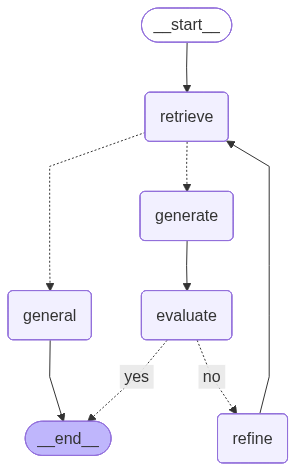

In [135]:
from IPython.display import Image, display

display(Image(rag_graph.get_graph().draw_mermaid_png()))